In [1]:
from grand import Topography, Reference, geoid_undulation
from grand import topography
from grand import ECEF, Geodetic, LTP, GRANDCS, CartesianRepresentation
import numpy as np

In [2]:
# Points delimiting GP300 array
latitude = np.array([41.4484450740, 41.3240186504, 41.2682974353, 41.2699858577, 
                     41.3599099238, 41.4116665473, 41.4484450740])
longitude= np.array([96.6878480765, 96.6703102286, 96.5824288586, 96.5302861717, 
                     96.4543304128, 96.5113155088, 96.6878480765])
height   = np.zeros(len(latitude))
subeiAllg= Geodetic(latitude=latitude, longitude=longitude, height=height)
subeiDg  = Geodetic(latitude=41.2699858577, longitude=96.5302861717, height=0) # This one is used as the reference of GRAND ref

# GP300 layout to GRAND coordinates
subeiAllG  = GRANDCS(subeiAllg, location=subeiDg) 

# update data
topography.update_data(coordinates=subeiDg, radius=1e4) # radius in meter

In [5]:
# Change datadir based on your grand location.
#datadir = '/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/data/topography'
#datadir = '/home/olivier/GRAND/soft/grand/grand/tools/data/topography/'
datadir = '../grand/grand/tools/data/topography/'
topo  = Topography(datadir)

elev1 = topo.elevation(subeiDg)                            # method 1. elevation wrt geoid.
elev2 = topography.elevation(subeiDg, 'GEOID')     # elevation wrt geoid (method 2)
elev2b= topography.elevation(subeiDg, 'ELLIPSOID') # elevation wrt ellipsoid (method 2)
print('Elevation of SubeiD.')
print('    elevation method1 [wrt geoid] :', elev1)
print('    elevation method2 [wrt geoid] :', elev2) 
print('    elevation [wrt ellipsoid]     :', elev2b)

undu = topography.geoid_undulation(subeiDg)        # geoid (ie sea level) undulation (departure from ellispoid)
print('    undulation         :', undu) 

# elevation based on LTP and GRAND coordinate system (reference=Reference.LOCAL).
ltp  = LTP(x=29000, y=29000, z=0, location=subeiDg, magnetic=True, orientation='NWU') # Create GRAND ref by hand
gcs1 = GRANDCS(x=29000, y=29000, z=0, location=subeiDg)     # z-coordinate does not matter. elevation wrt to XY-plane at (x,y).
print('Elevation based on LTP/GRAND coordinate system.')
print('    elevation LTP   [wrt geoid] :', topography.elevation(ltp))
print('    elevation GRAND [wrt geoid] :', topography.elevation(gcs1))
print('    elevation LTP   [wrt local] :', topography.elevation(ltp, 'LOCAL'))
print('    elevation GRAND [wrt local] :', topography.elevation(gcs1, 'LOCAL'))


Elevation of SubeiD.
    elevation method1 [wrt geoid] : nan
    elevation method2 [wrt geoid] : 2025.9777673666085
    elevation [wrt ellipsoid]     : 2013.9643291656948
    undulation         : -12.013438200913718
Elevation based on LTP/GRAND coordinate system.
    elevation LTP   [wrt geoid] : 2195.0880458952765
    elevation GRAND [wrt geoid] : 2195.0880458952765
    elevation LTP   [wrt local] : 2064.796735558535
    elevation GRAND [wrt local] : 2064.796735558535


In [7]:
# Get the local ground elevation over a grid and plot it.

# Build a meshgrid for ground topography
distm = 29000
xmin = -distm
xmax = +distm
ymin = -distm
ymax = +distm
nsteps = 401 # nb of topo steps
x = np.linspace(xmin, xmax, nsteps) 
y = np.linspace(ymin, ymax, nsteps)
X, Y = np.meshgrid(x, y)
ground_grid = GRANDCS(x=X.flatten(), y=Y.flatten(), z=np.zeros(X.size), location=subeiDg)  

# Calculate elevation wrt geoid and GRAND coordinate frame.
zg = topography.elevation(ground_grid, 'GEOID')                  # Fetch elevation data wrt sea level. reference=GEOID.
zG = topography.elevation(ground_grid, 'LOCAL') # Fetch elevation data wrt GRAND frame.

zg = zg.reshape(X.shape) # Format as matrix
zG = zG.reshape(X.shape) # Format as matrix
deltaz = zg - zG;        # Difference between geodetic height and z_GRAND (= Earth curvature)

# Now go to Geodetic coordinates
ground_grid_geo = Geodetic(ground_grid)

# Now reformat output
lat = ground_grid_geo.latitude.reshape(X.shape) # Format as matrix
lat = lat[0] # Grab first line
lon = ground_grid_geo.longitude.reshape(X.shape) # Format as matrix
lon = lon[:,0] #Grab first col


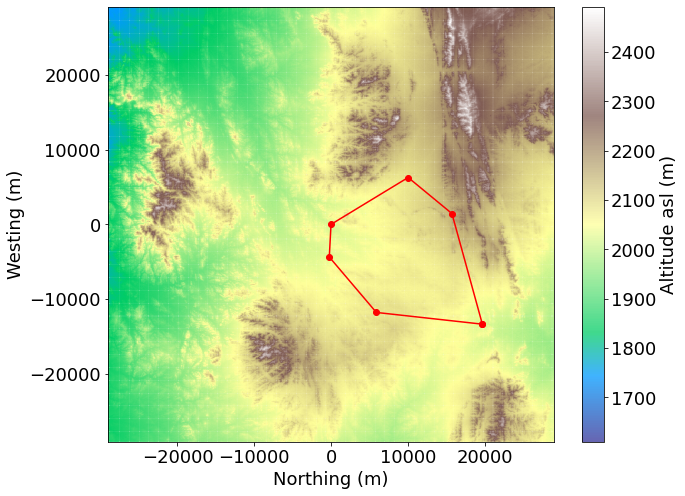

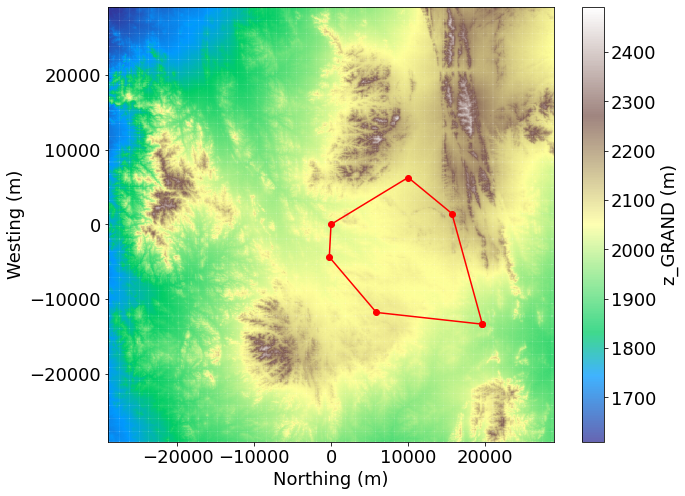

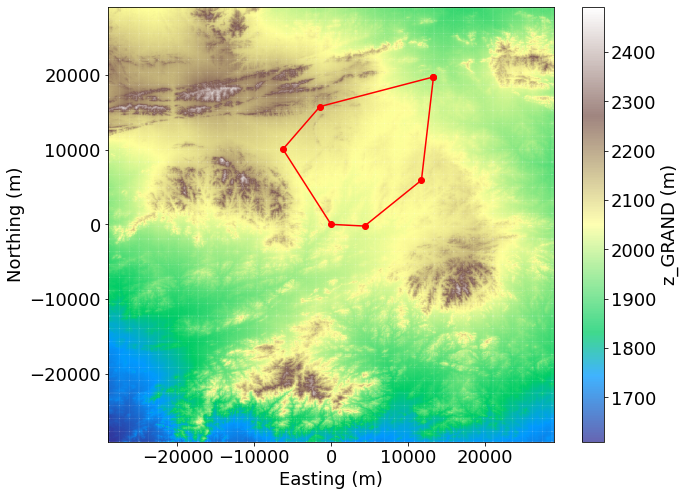

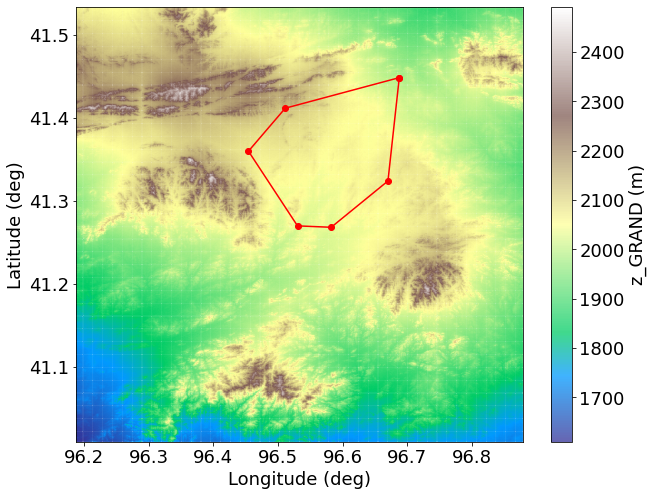

In [13]:
# Now plot the terrain
from matplotlib import cm, colors, pyplot as pl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
params = {'legend.fontsize': 16,
          'axes.labelsize' : 18,
          'axes.titlesize' : 23,
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'figure.figsize' : (10, 8),
          'axes.grid'      : True,
          'pcolor.shading' : 'auto'}
pl.rcParams.update(params)

norm = colors.Normalize(vmin=np.amin(zG), vmax=np.amax(zg))
#m    = cm.ScalarMappable(cmap='terrain',norm=norm)

# Just a few tests to better understand the subtilities of topography.elevation 
# for inputs in GRAND OR Geodetic coords.

# Plot with z = Geodetic z
pl.figure()
pl.pcolor(x,y,zg, cmap='terrain', alpha=0.75, norm=norm)
pl.plot(subeiAllG.x,subeiAllG.y,'or-')
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
pl.colorbar(label='Altitude asl (m)')

# Topography plot x = North, y = West
pl.figure()
pl.pcolor(x,y,zG, cmap='terrain', alpha=0.75, norm=norm)
pl.plot(subeiAllG.x,subeiAllG.y,'or-')
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
pl.colorbar(label='z_GRAND (m)')
#pl.savefig('/Users/rameshkoirala/Documents/GRAND/grandlib/Plots/topography_subei.png', bbox_inches='tight')


# Topography plot x = East, y = North (standard)
pl.figure()
pl.pcolor(-y,x,zG.T, cmap='terrain', alpha=0.75, norm=norm)
pl.plot(-subeiAllG.y,subeiAllG.x,'or-')
pl.xlabel('Easting (m)')
pl.ylabel('Northing (m)')
pl.colorbar(label='z_GRAND (m)')

# Plot in Goedetic coordinates (z = GRAND height)
pl.figure()
pl.pcolor(lon,lat,zG.T, cmap='terrain', alpha=0.75, norm=norm)
pl.plot(subeiAllg.longitude,subeiAllg.latitude,'or-')
pl.xlabel('Longitude (deg)')
pl.ylabel('Latitude (deg)')
pl.colorbar(label='z_GRAND (m)')

pl.show()

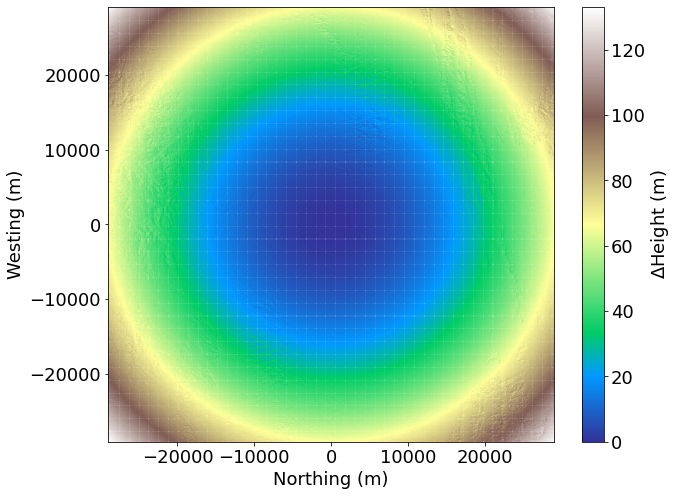

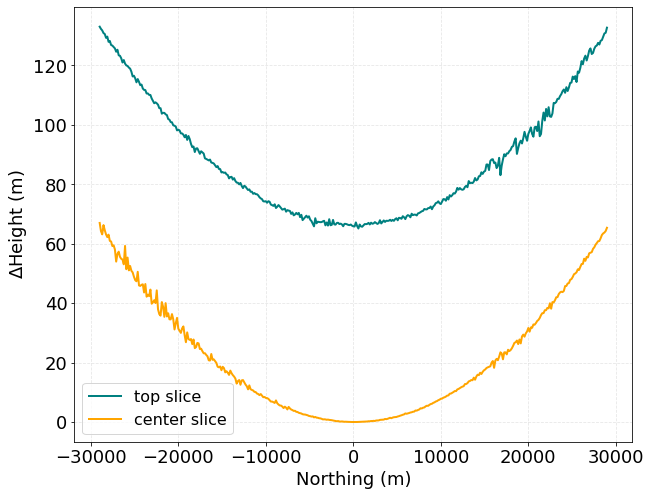

In [14]:
# Difference with GRAND altitudes = Earth curvature
norm = colors.Normalize(vmin=np.amin(deltaz), vmax=np.amax(deltaz))
m = cm.ScalarMappable(cmap='terrain',norm=norm)

pl.figure()
pl.pcolor(x,y,deltaz, cmap='terrain', alpha=0.75)
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
bar = pl.colorbar(m)
bar.set_label('$\Delta$Height (m)')
#pl.savefig('/Users/rameshkoirala/Documents/GRAND/grandlib/Plots/earth_curvature.png', bbox_inches='tight')

pl.figure()
pl.plot(x,deltaz[0], 'teal', label='top slice', lw=2)
pl.plot(x,deltaz[round(nsteps/2)], 'orange', label='center slice', lw=2)
pl.xlabel('Northing (m)')
pl.ylabel('$\Delta$Height (m)')
pl.legend()
pl.grid(ls='--', alpha=0.3)
pl.show()

Distance to ground: 11864.534490089432


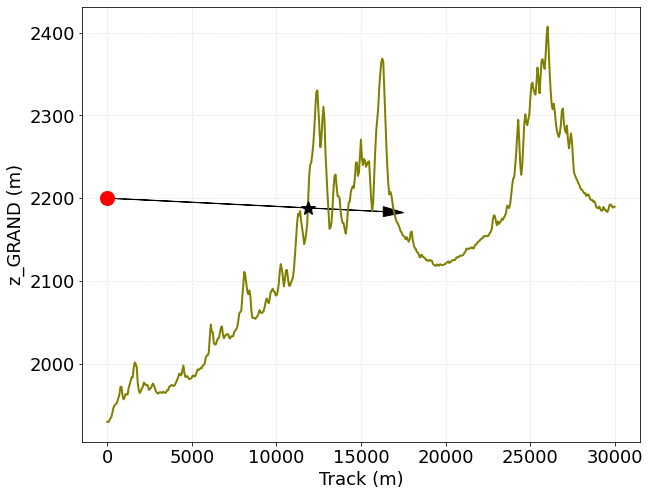

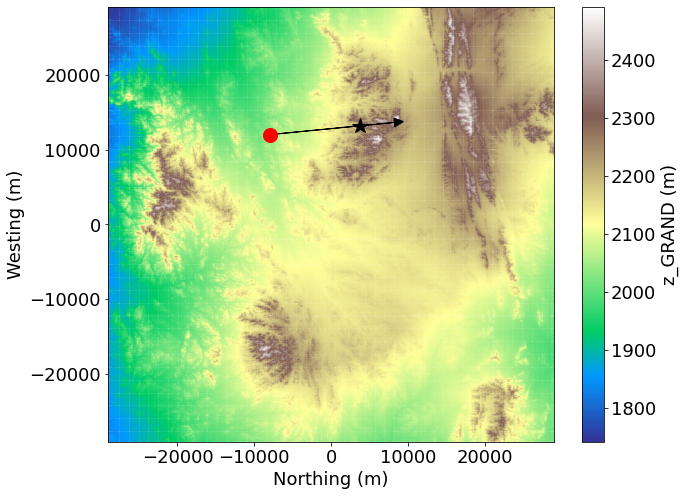

In [12]:
# Now check when a given trajectory meets ground
# Does not match with distance function... To be solved.

def arrow(x,y):
    dx, dy= x[-1]-x[0], y[-1]-y[0]
    arrow_l  = np.sqrt(dx**2 + dy**2)
    return x[0], y[0], dx, dy, arrow_l

#direction = CartesianRepresentation(x=100, y=10, z=-0.1)   # Traj = direction vector in GRAND ref
direction = GRANDCS(x=100, y=10, z=-0.1, location=subeiDg)
x0   = GRANDCS(x=-8000,y=12000,z=2200, location=subeiDg) # Initial point along traj (in GRAND ref)
dirE = np.matmul(x0.basis.T, direction)   # GRAND --> ECEF. input direction must be in ECEF. ToDo: Fix this.
distance1 = topography.distance(x0, dirE) # direction vector here is in ECEF frame.
#direction = np.matmul(x0.basis, dirE)    # ECEF --> GRAND. change direction vector back to GRAND frame.
print("Distance to ground:",distance1)

# Build traj
u    = np.linspace(0,3.e4,501)  # Distance from x0 (meters)
dirn = direction/np.linalg.norm(direction) # normalize direction vector
traj = dirn * u + x0 

# Get elevation below traj
traj_grand = GRANDCS(x=traj[0], y=traj[1], z=traj[2], location=subeiDg)  # Compute traj coordinates
ztG        = topography.elevation(traj_grand, reference='LOCAL') # z-coordinate of ground in GRAND ref

icrash     = np.argmin(abs(u-distance1)) # index of trajectory closest to intersection to ground

# Side view
pl.figure()
ka, kha, dka, dkha, arrow_l  = arrow(u[:icrash+int(.15*len(u))], traj[2][:icrash+int(.15*len(u))])
pl.arrow(ka, kha, dka, dkha, 
         width=0.2, head_length=20*np.diff(u)[0], head_width=200*np.diff(traj[2])[0],
         facecolor='k')
pl.plot(u,ztG,'olive', lw=2) # ground
pl.plot(u[icrash],traj[2,icrash],'*k', markersize=15) #intersection with ground
pl.plot(0,x0.z,'or', markersize=14)   # initial point
pl.xlabel('Track (m)')
pl.ylabel('z_GRAND (m)')
pl.grid(ls='--', alpha=0.3)
pl.savefig('/Users/rameshkoirala/Documents/GRAND/grandlib/Plots/topography_along_direction.png')


# Top view
pl.figure(figsize=(10,8))
norm = colors.Normalize(vmin=np.amin(zg), vmax=np.amax(zg))
m = cm.ScalarMappable(cmap='terrain',norm=norm)
pl.pcolor(x,y,zG, cmap='terrain', alpha=0.75)
ka, kha, dka, dkha, arrow_l  = arrow(traj[0][:icrash+int(.15*len(u))], traj[1][:icrash+int(.15*len(u))])
pl.arrow(ka, kha, dka, dkha, 
         #width=6, head_length=.1*arrow_l, head_width=0.08*arrow_l,
         width=6, head_length=20*np.diff(traj[0])[0], head_width=200*np.diff(traj[1])[0],
         facecolor='k')
pl.plot(x0.x,x0.y,'or', markersize=14)
pl.plot(traj[0,icrash],traj[1,icrash],'*k', markersize=16) #intersection with ground
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
bar = pl.colorbar(m)
bar.set_label('z_GRAND (m)')
pl.savefig('/Users/rameshkoirala/Documents/GRAND/grandlib/Plots/topography_and_direction.png')
pl.show()